In [61]:
## comparing NN to random forest for sonar/satellite data set

# bugs to fix (03.13.19): subplotting results

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os,sys
from rfpimp import oob_dropcol_importances, cv_importances, oob_importances, dropcol_importances, importances, plot_importances
from matplotlib.ticker import FormatStrFormatter

In [2]:
## define a function for calculating importances by MSE
def mse(model, X, y, sample_weights=None):
    y_pred = model.predict(X)
    mse = np.sum((y-y_pred)**2) / np.max(y.shape)
    return mse

In [3]:
## previous NN data organization
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/updated_nasc-sonar.csv"

d = pd.read_csv(path)

#dfile = '../data/2018-03-04_nasc-sonar.csv'
#d = pd.read_csv(dfile)

d = d.query('NASC > 0')  # filter out zero-value NASC
d = d.assign(log_nasc = np.log(d.NASC))  # log transform of NASC
d = d.assign(closest_chlor_a = np.log(d.closest_chlor_a))
d = d.assign(depth_m = d.depth_m.astype(np.float64))
d = d.query('log_nasc < 17.5')

feats = [
    'Lon', 
    'Lat',
    'distance_from_shore_m',
    'depth_m',
    'log_nasc', 
    'wavelength', 
    'depth_bin',
    'Day'
]
filter_col = [col for col in d if (col.startswith('closest') or col in feats)]
d = d[filter_col]
d = d.dropna()

z = d[['Lat','Lon','closest_sst','closest_chlor_a','distance_from_shore_m','depth_m',\
        'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
        'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
        'closest_Rrs_667','closest_Rrs_678','Day']]

wavelengths = d.wavelength.unique()
wavelengths.sort()
#wavelengths

depth_bins = d.depth_bin.unique()
#depth_bins

subd = d.query('wavelength == ' + str(wavelengths[0]))
subd = subd.query("depth_bin == '" + str(depth_bins[0]) + "'")
x = subd.drop(['log_nasc', 'wavelength', 'depth_bin'], axis=1)
x[:] = preprocessing.scale(x) # [:] retains dataframe
y = subd.log_nasc
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [4]:
## fit a MLP NN
mlp = MLPRegressor(hidden_layer_sizes=(50, 40, 30, 20, 10), max_iter=100000)
mlp.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 40, 30, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

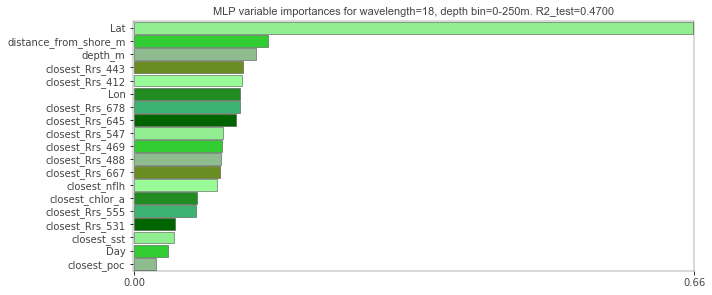

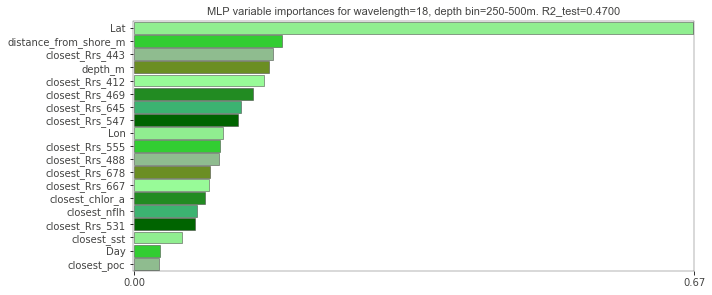

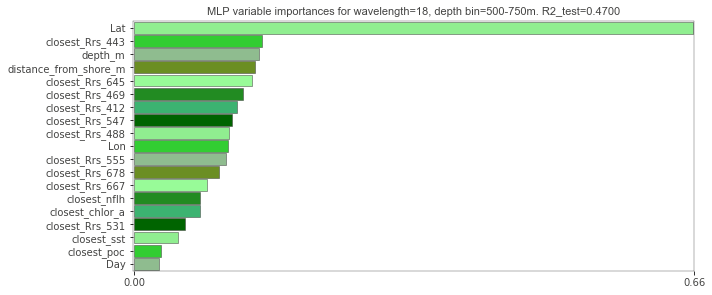

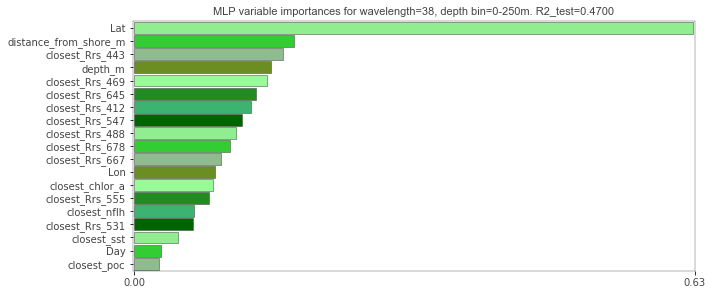

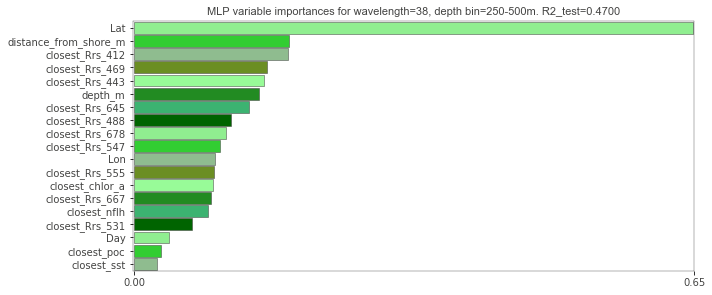

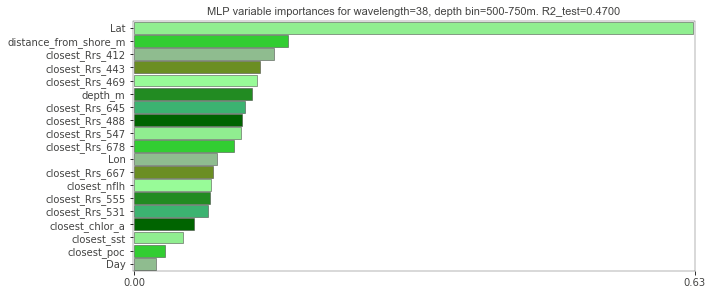

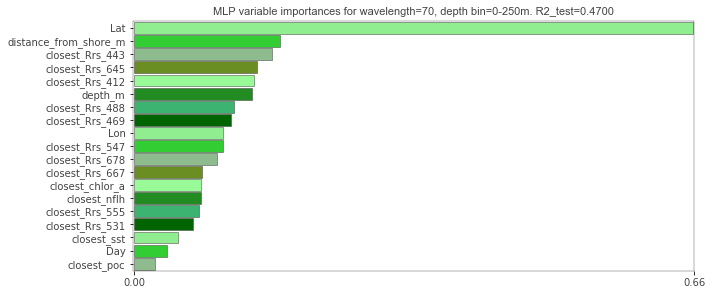

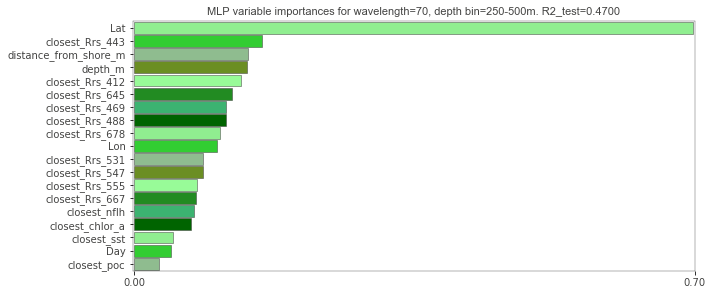

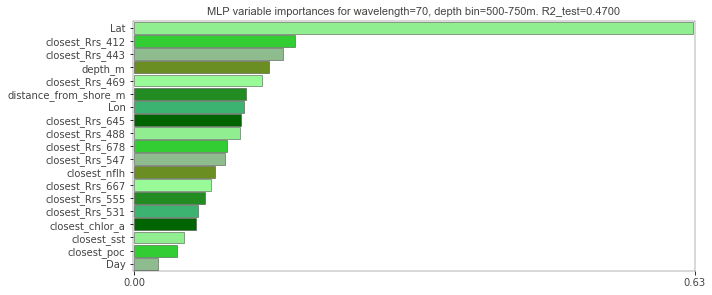

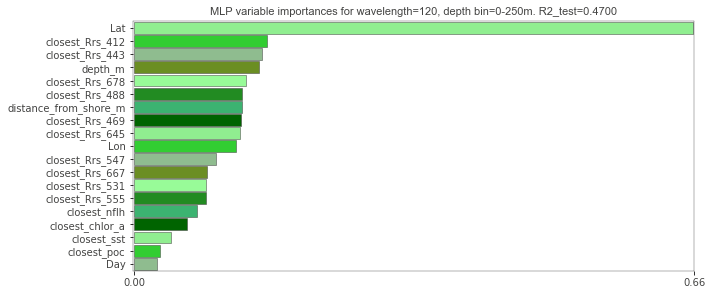

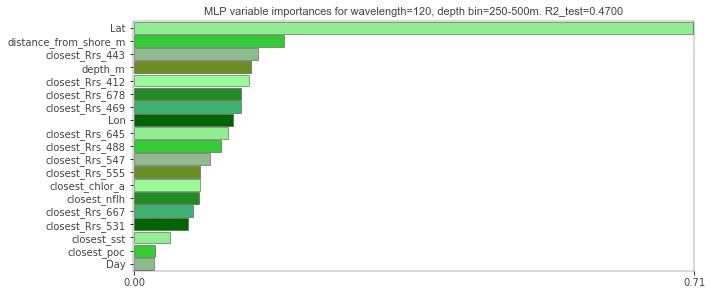

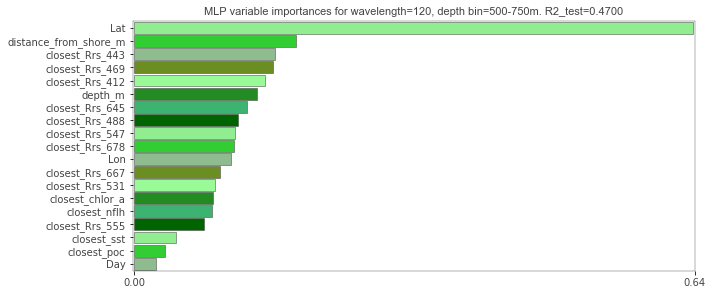

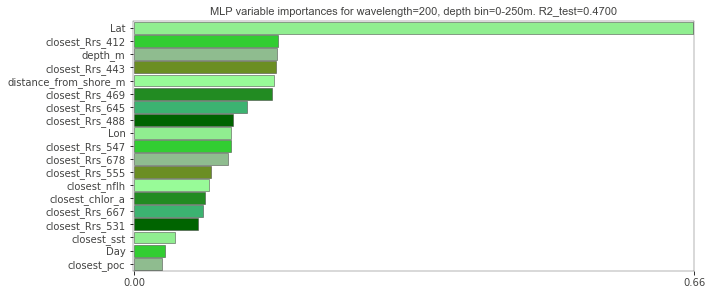

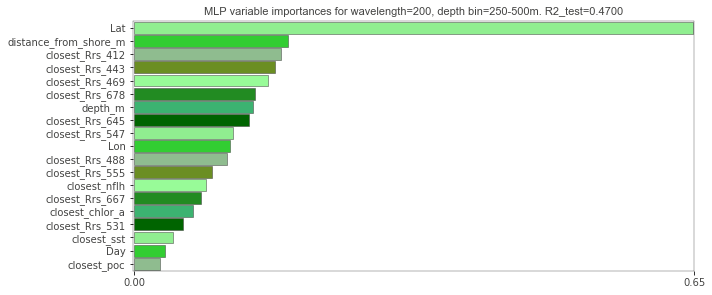

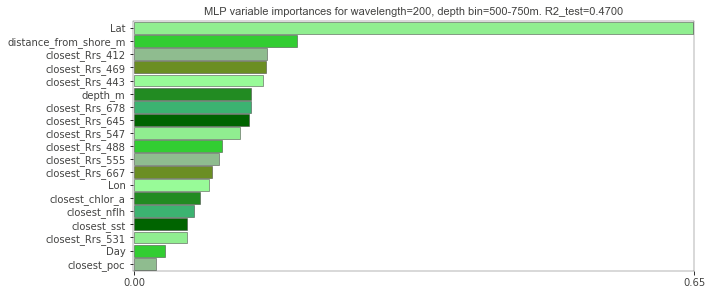

In [59]:
## NN importances

# R2_test
color = ['lightgreen','limegreen','darkseagreen','olivedrab','palegreen','forestgreen','mediumseagreen','darkgreen']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        ## calculate importances via permutation using model.score()
        mlp_imp = importances(mlp, x_test, y_test)
        title = "MLP variable importances for wavelength={0}, depth bin={1}. R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], mlp.score(x_test, y_test))
        plot_importances(mlp_imp, title=title, width=10, color =color)
        plt.show()
        

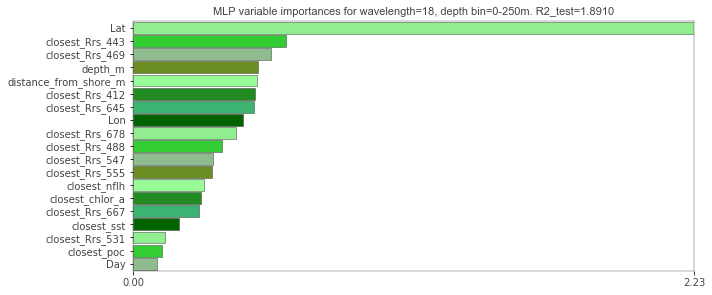

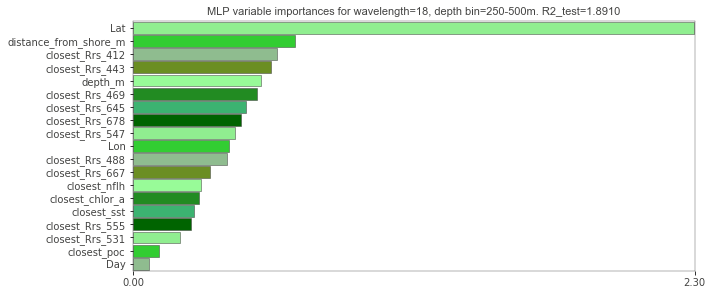

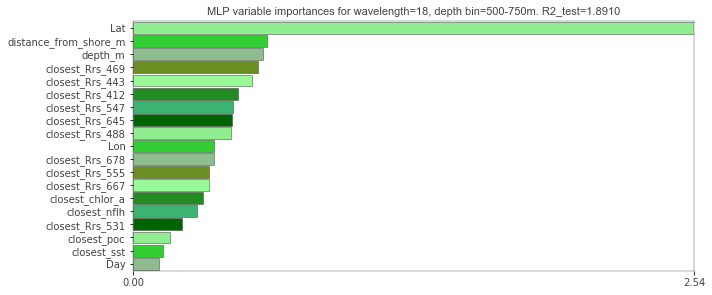

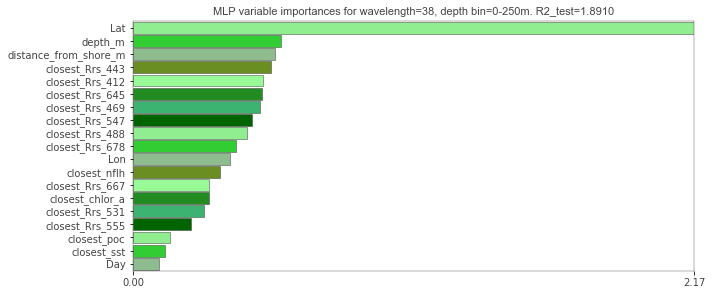

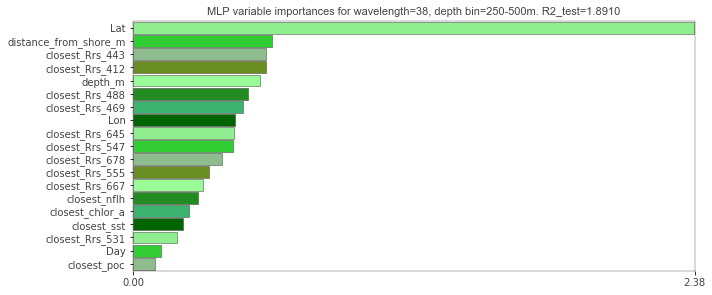

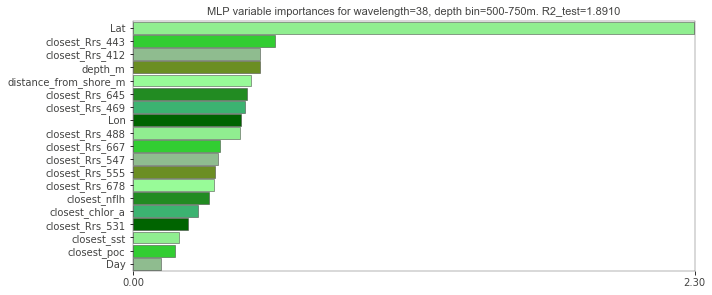

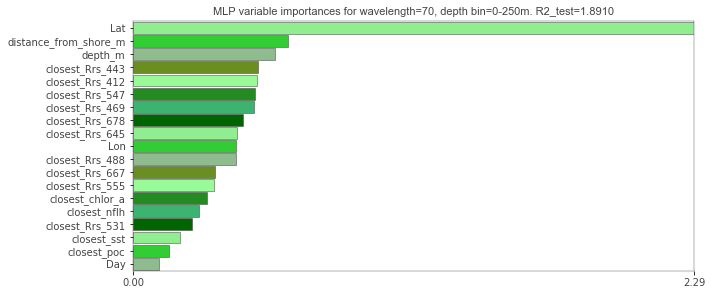

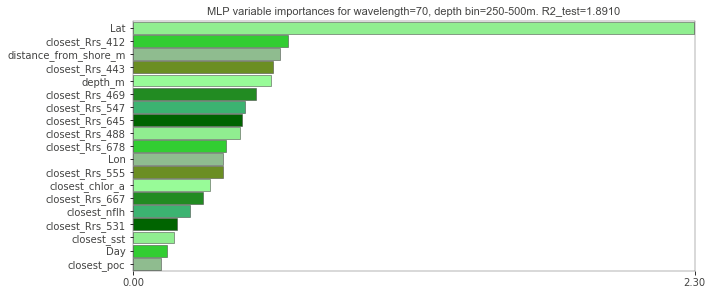

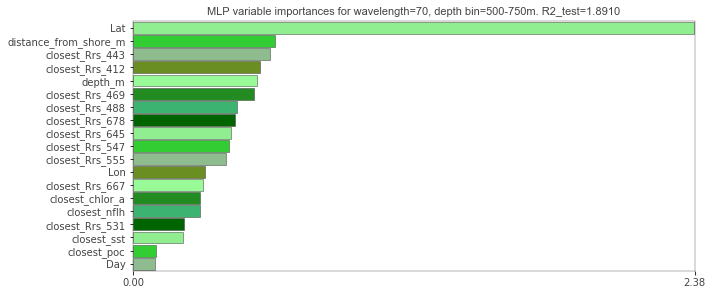

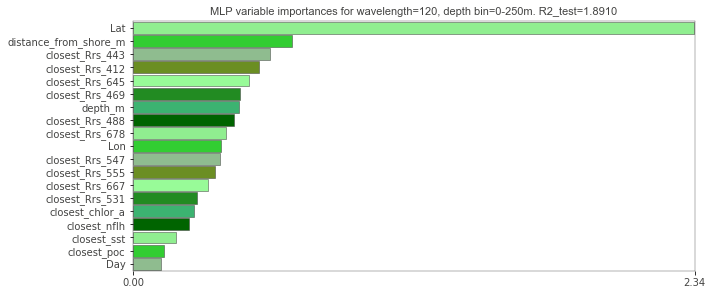

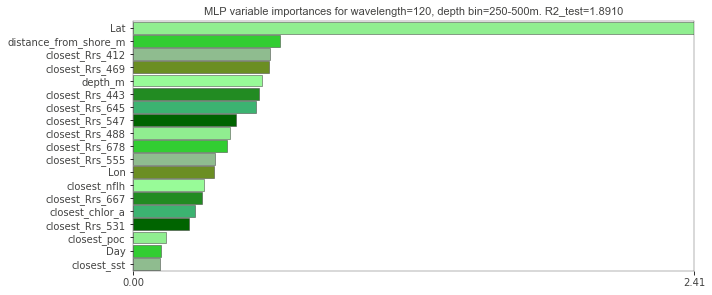

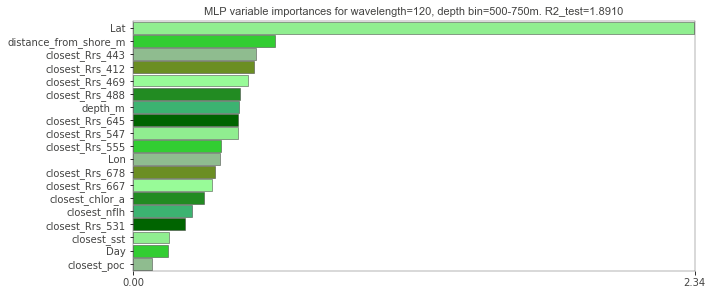

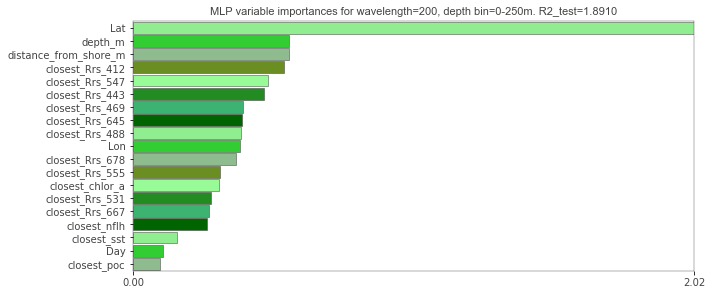

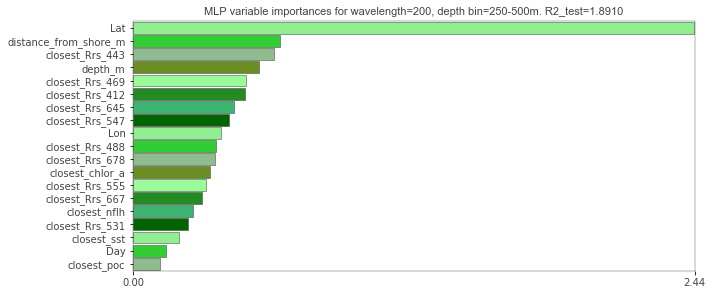

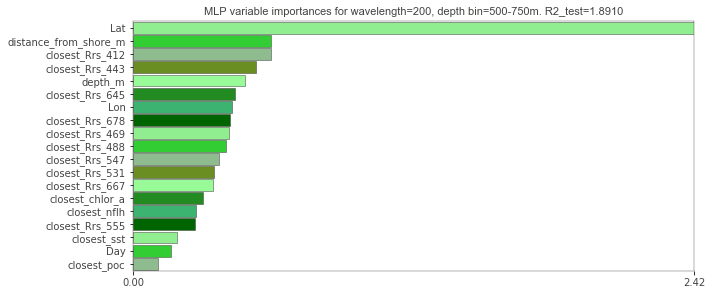

In [63]:
## NN importances, cont.

#MSE
nn_mse_list = []
color = ['lightgreen','limegreen','darkseagreen','olivedrab','palegreen','forestgreen','mediumseagreen','darkgreen']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        ## do the same for MSE
        mlp_imp_mse = importances(mlp, x_test, y_test, metric=mse)
        nn_mse_list.append(mlp_imp_mse)
        title = "MLP variable importances for wavelength={0}, depth bin={1}. R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(mlp,x_test, y_test))
        mlp_imp_mse.Importance = np.abs(mlp_imp_mse.Importance.values)
        plot_importances(mlp_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color) #sort helps keep same top-down look
        plt.show()

In [55]:
## Random Forest importances

## fit a RF to the same data
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

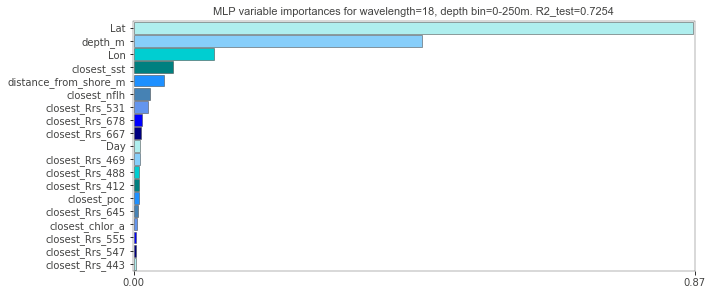

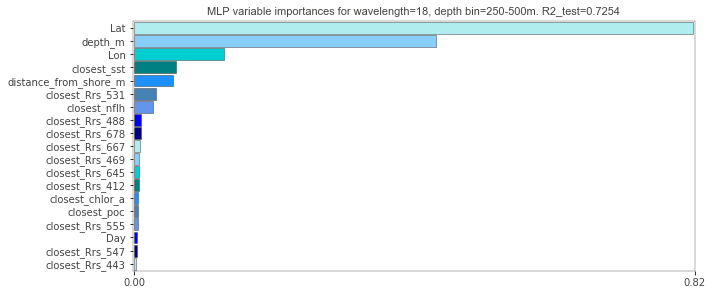

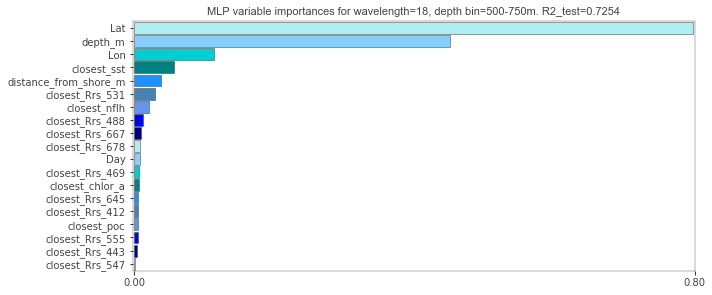

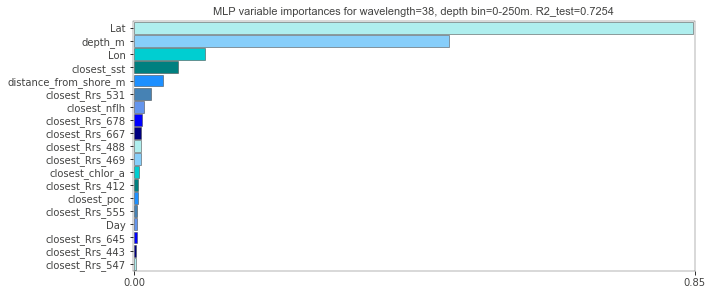

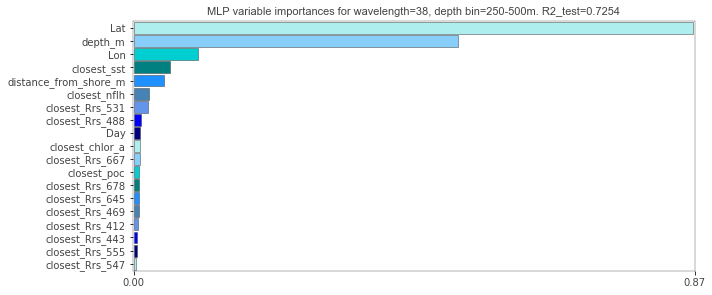

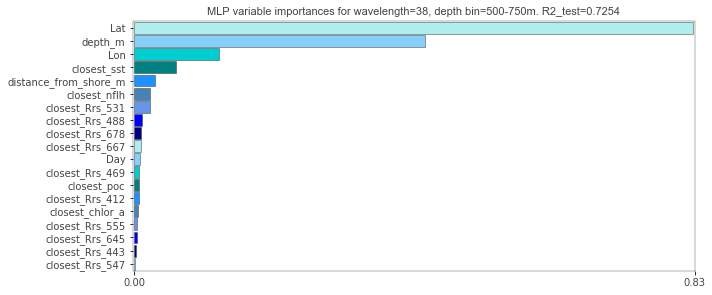

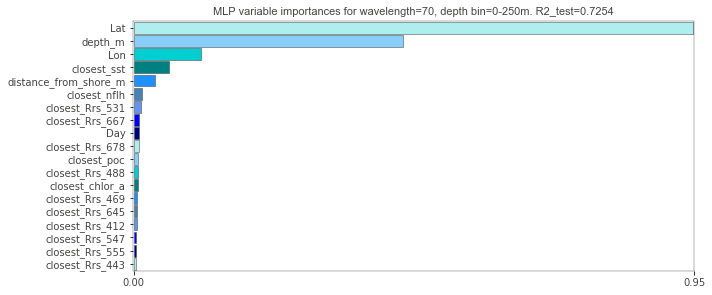

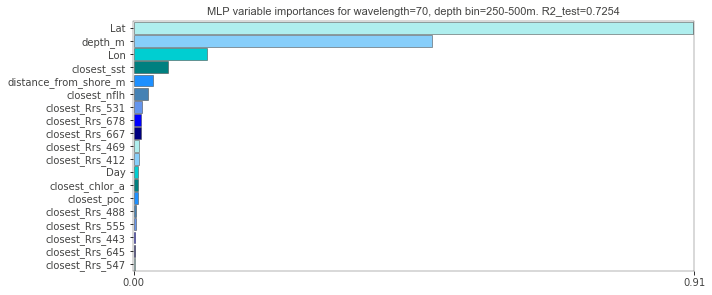

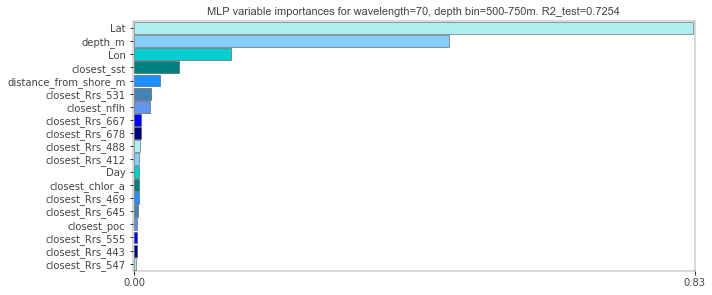

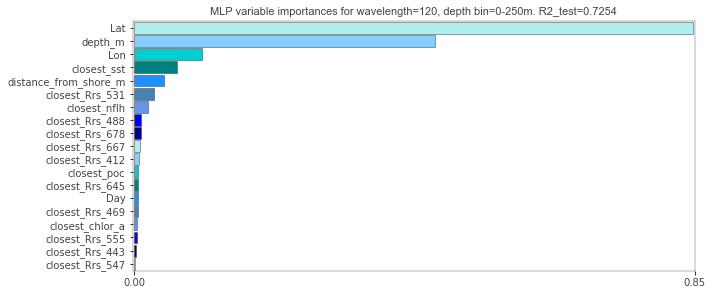

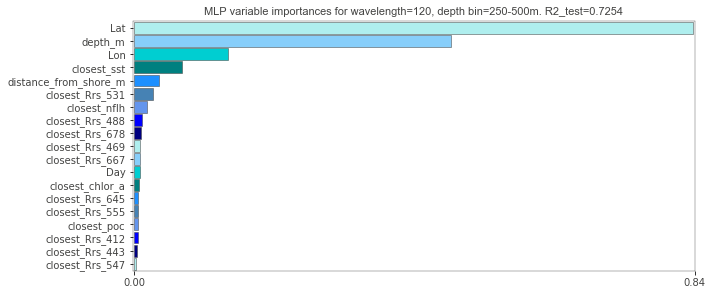

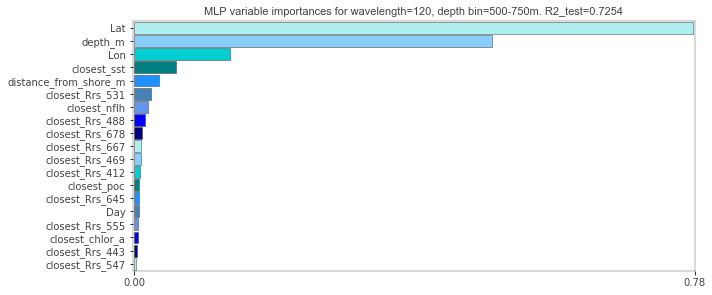

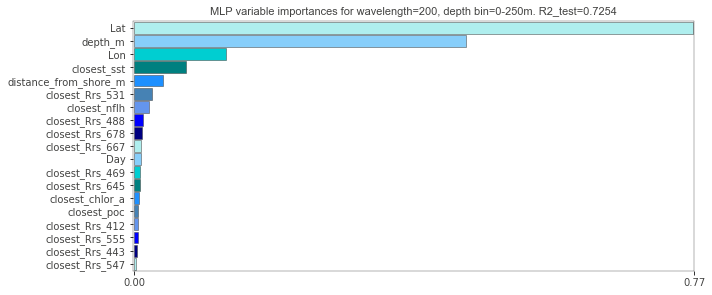

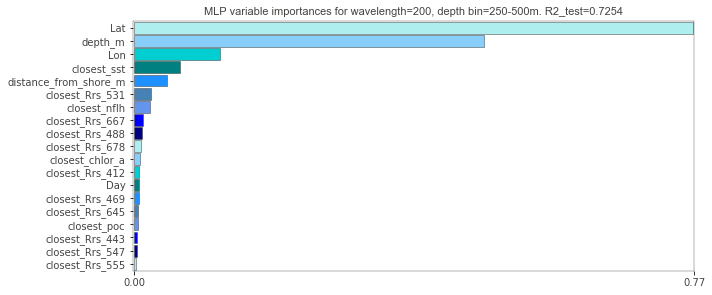

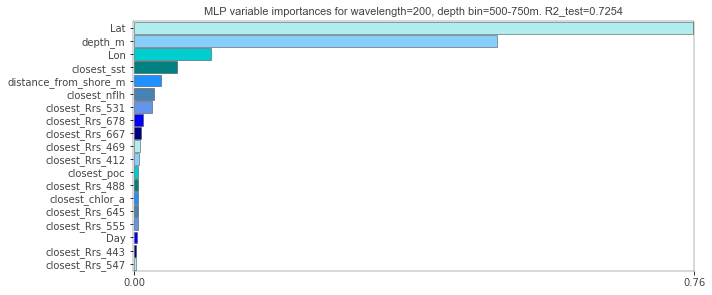

In [57]:
## Random Forest importances
# R2_test
color = ['paleturquoise','lightskyblue','darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        ## calculate importances via permutation using model.score()
        perm_imp = importances(rf, x_test, y_test)
        title = "MLP variable importances for wavelength={0}, depth bin={1}. R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], rf.score(x_test, y_test))
        plot_importances(perm_imp, title=title, width=10, color =color)
        plt.show()
        

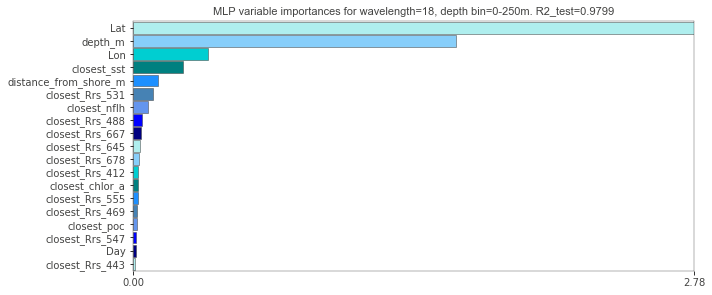

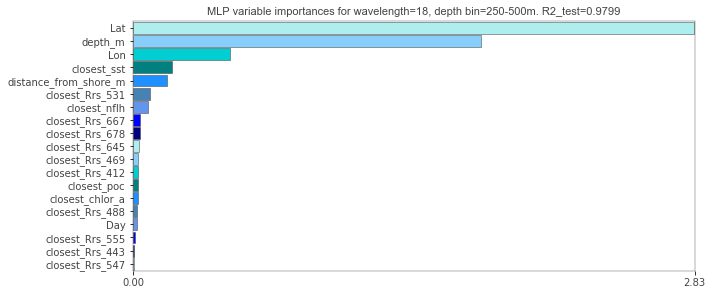

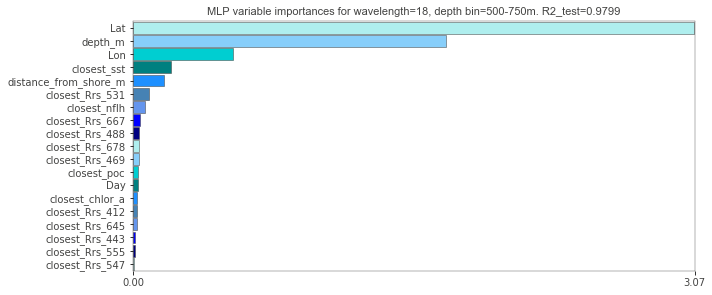

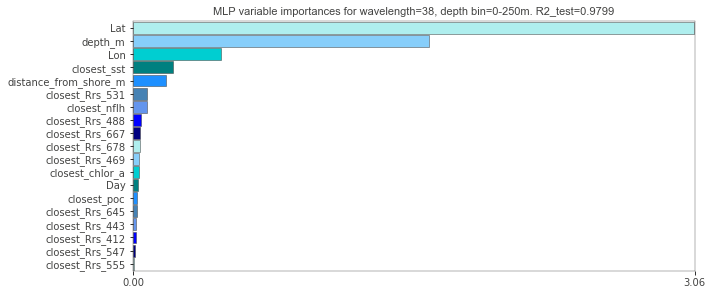

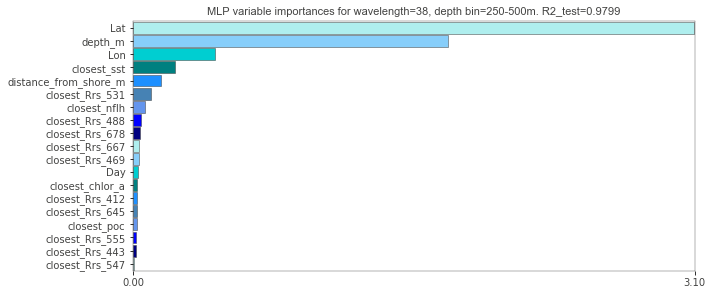

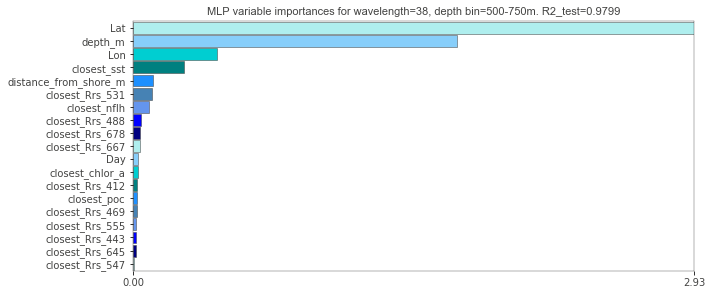

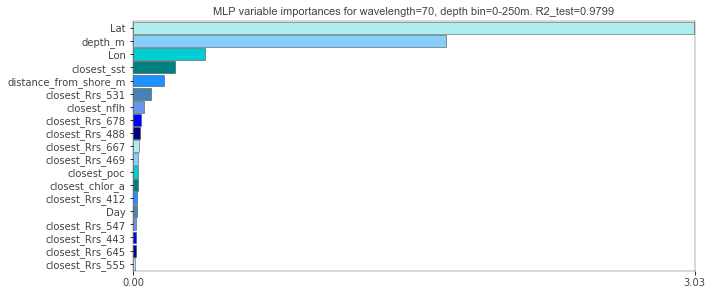

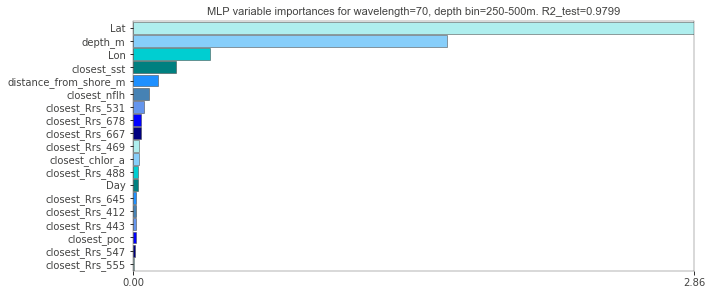

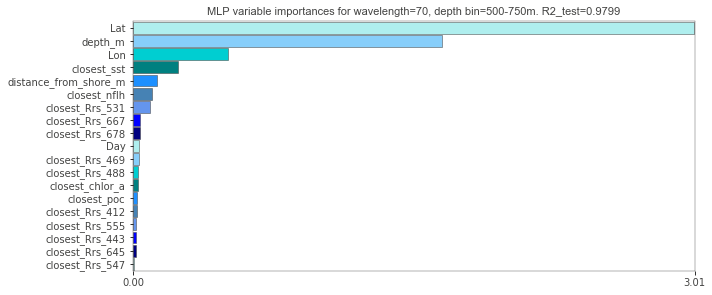

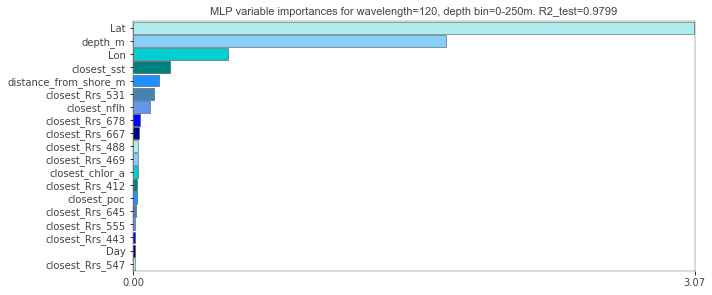

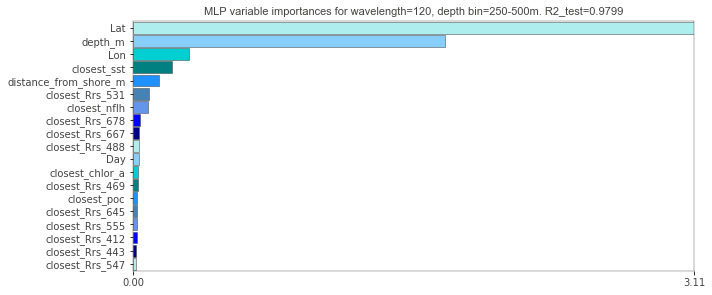

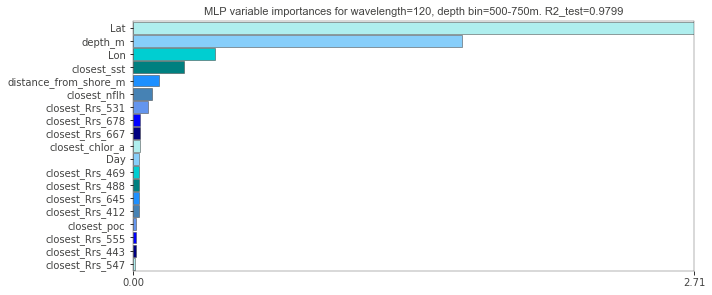

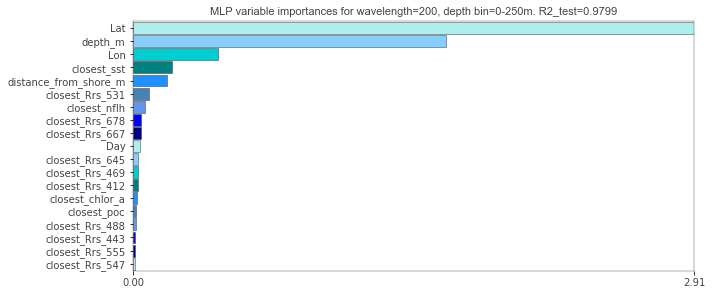

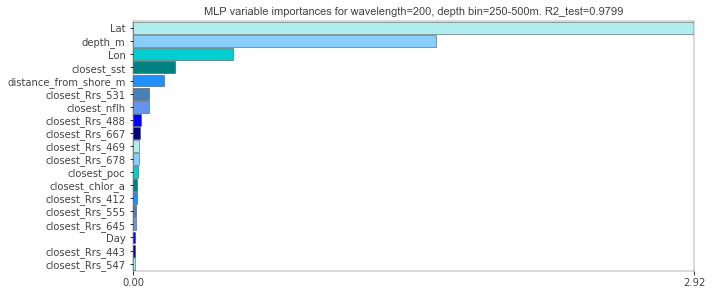

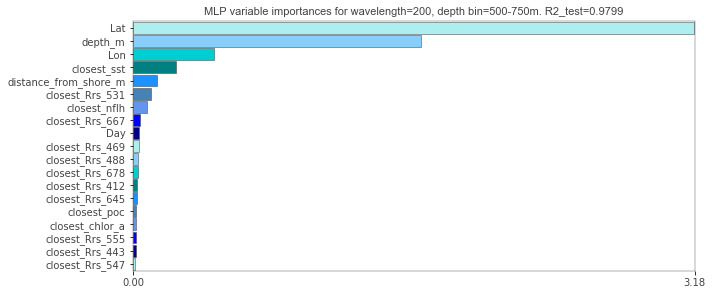

In [78]:
## Random Forest importances
# MSE
rf_mse_list = []
color = ['paleturquoise','lightskyblue','darkturquoise','teal','dodgerblue','steelblue','cornflowerblue','blue','navy']
for i, wavelength in enumerate(wavelengths):
    for j, depth_bin in enumerate(depth_bins):

        ## do the same for mse
        rf_imp_mse = importances(rf, x_test, y_test, metric=mse)
        #rf_mse_list.append(rf_imp_mse)
        title = "MLP variable importances for wavelength={0}, depth bin={1}. R2_test={2:0.4f}".format(wavelengths[i], depth_bins[j], mse(rf,x_test, y_test))
        rf_imp_mse.Importance = np.abs(rf_imp_mse.Importance.values)
        rf_mse_list.append(rf_imp_mse.Importance)
        plot_importances(rf_imp_mse.sort_values(by='Importance', ascending=False), title=title, width=10,color=color)
        plt.show()
